In [ ]:
import random
from mxnet import autograd, np, npx

In [1]:
import tensorflow as tf
import numpy as np
import random
from tensorflow import keras

In [ ]:
def synthetic_data(w, b, num_examples):
    X = np.random.normal(0, 1, (num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [ ]:
true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(features[:, 0], labels)

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order 
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = np.array(indices[i:min(i + batch_size, num_examples)])
        yield tf.constant(features[batch_indices]), tf.constant(labels[batch_indices])

In [ ]:
def linreg(X, w, b):
    return X @ w + b

def squared_loss(y_hat, y):
    return tf.reduce_sum(tf.pow(y_hat - tf.reshape(y, y_hat.shape), 2)) / (2 * len(y))

def sgd(w, grad, lr):
    return w - tf.reduce_sum(grad, lr)

In [ ]:
model = keras.models.Sequential(keras.layers.Dense(1))
loss_func = keras.losses.mean_squared_error
optimizer = keras.optimizers.SGD(learning_rate=0.03)

In [ ]:
BATCH_SIZE = 10
EPOCH = 4
train_set = tf.data.Dataset.from_tensor_slices((features, labels)).shuffle(100).batch(BATCH_SIZE)
for epoch in range(EPOCH):
    for X, y in train_set:
        with tf.GradientTape() as tape:
            theta = model(X)
            loss = tf.reduce_sum(loss_func(theta, y)) / len(y)
        grad = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(grad, model.variables))
    main_loss = tf.reduce_sum(loss_func(model(features), labels)) / len(features)
    print(f'Epoch {epoch} loss:{main_loss}')

In [ ]:
model.variables

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
loss = keras.losses.sparse_categorical_crossentropy
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.95)
metric = keras.metrics.Accuracy()

In [ ]:
batch_size = 32
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(100).batch(batch_size)
for epoch in range(10):
    for X, y in train_set:
        with tf.GradientTape() as tape:
            l = tf.reduce_sum(loss(y, model(X))) / len(y)
        grad = tape.gradient(l, model.variables)
        optimizer.apply_gradients(zip(grad, model.variables))
    y_pred = tf.argmax(model(x_test), axis=1)
    metric.update_state(y_pred, y_test)
    print(f"Epoch {epoch}: accuracy test: {metric.result()}")
    metric.reset_state()

In [ ]:
num_inputs, num_outputs, num_hiddens = 784, 10, 1000
w1 = tf.Variable(np.random.normal(size=(num_inputs, num_hiddens)), dtype=tf.float32)
b1 = tf.Variable(np.random.normal())
w2 = tf.Variable(np.random.normal(size=(num_hiddens, num_outputs)), dtype=tf.float32)
b2 = tf.Variable(np.random.normal())

params = [w1, b1, w2, b2]

In [ ]:
def relu(X):
    return tf.maximum(X, 0)

def net(X):
    X = tf.cast(tf.reshape(X, [-1, 784]), dtype=tf.float32)
    H = relu(X @ w1 + b1)
    return tf.keras.activations.softmax(H @ w2 + b2, axis=-1)

loss = keras.losses.sparse_categorical_crossentropy
optimizer = keras.optimizers.Adam()
metric = keras.metrics.Accuracy()

In [ ]:
batch_size = 32
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(100).batch(batch_size)
for epoch in range(5):
    for X, y in train_set:
        with tf.GradientTape() as tape:
            l = tf.reduce_sum(loss(y, net(X))) / len(y)
        grad = tape.gradient(l, params)
        optimizer.apply_gradients(zip(grad, params))
    y_pred = tf.argmax(net(x_test), axis=1)
    metric.update_state(y_pred, y_test)
    print(f"Epoch {epoch}: accuracy test: {metric.result()}")
    metric.reset_state()

In [ ]:
a = tf.reshape(x_train, [-1, 784])[0]

In [ ]:
X = tf.cast(tf.reshape(x_train, [-1, 784]), dtype=tf.float64)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

In [ ]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              metrics=["accuracy"])


In [ ]:
# x_train = x_train / 255.0
# x_test = x_test / 255.0
model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test))

In [49]:
def custom_loss(alpha):
    def log_rmse(y_true, y_pred):
        # Log root mean square error
        diff = tf.math.log(y_true) - tf.math.log(y_pred)
        diff_pow_2 = tf.pow(diff, 2)
        diff_mean = tf.reduce_mean(diff_pow_2)
        return alpha * tf.sqrt(diff_mean)
    
    return log_rmse


In [50]:
class CustomLoss(keras.losses.Loss):
    def __init__(self, alpha, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.name = 'haha'
        
    def call(self, y_true, y_pred):
        return custom_loss(self.alpha)(y_true, y_pred)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "alpha": self.alpha}

In [51]:
custom_loss(0.5)(tf.constant([1.0]), tf.constant([2.0]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.3465736>

In [52]:
cus_loss = CustomLoss(0.5)

In [54]:
cus_loss(tf.constant([1.0]), tf.constant([2.0]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.3465736>

In [65]:
def custom_activation(alpha):
    def my_activation(x):
        if x > 1:
            return tf.constant(x, dtype=tf.float32)
        else :
            return tf.maximum(x - alpha, 0)
    return my_activation

In [ ]:
class CustomActivation(keras.layers.Layer):
    

In [67]:
custom_activation(0.5)(0.3)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [68]:
def custom_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

In [69]:
def custom_regularizer(weights, alpha):
    return alpha * tf.reduce_sum(tf.abs(weights))

In [73]:
def custom_constraint(weights, threshold):
    return tf.where(weight > threshold, tf.zeros_like(weights), weights)

In [84]:
class CustomMetric(keras.metrics.Metric):
    def __init__(self, alpha, **kwargs):
        super().__init(**kwargs)
        self.alpha = alpha
        self.log_rmse = custom_loss(alpha)
        self.total = self.add_weight("total", initializer='zeros')
        self.count = self.add_weight("count", initializer='zeros')
    def update_state(self, y_true, y_pred):
        metric = self.log_rmse(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), dtype=tf.float32))
        
    def result(self):
        return self.total / self.count
    
    def get_config(self):
        base_config = self.get_config()
        return {**base_config, 'alpha': self.alpha}

In [79]:
tf.keras.optimizers.get?

In [88]:
class CustomOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, **kwargs):
        super().__init__(**kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        
    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, "prev_var")
        for var in var_list:
            self.add_slot(var, "prev_grad")
            
    def _resource_apply_dense(self, grad, var):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # get learning rate decay

        new_var_m = var - grad * lr_t

        
        pv_var = self.get_slot(var, "prev_var")
        pg_var = self.get_slot(var, "prev_grad")
        
        if self._is_first:
            self._is_first = False
            new_var = new_var_m
        else:
            cond = grad*pg_var >= 0
            avg_weights = (pv_var + var)/2.0
            new_var = tf.where(cond, new_var_m, avg_weights)
            
        pv_var.assign(var)
        pg_var.assign(grad)

        var.assign(new_var)
        
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }
        

In [85]:
a = tf.constant(1.0)

In [87]:
a.dtype.base_dtype

tf.float32

In [109]:
class CustomLayer(keras.layers.Layer):
    def __init__(self, units, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        self.kernel = self.add_weight("kernel",
                                      initializer='glorot_normal',
                                      shape=(batch_input_shape[-1], self.units))
        
        self.bias = self.add_weight("bias",
                                    shape=(self.units),
                                    initializer='zeros')
    
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'units': self.units, 'activation': self.activation}
        

In [110]:
layer = CustomLayer(10)

In [113]:
!pip install pyconll

In [119]:
!curl https://raw.githubusercontent.com/VinAIResearch/PhoNER_COVID19/main/data/syllable/test_syllable.conll -o test_syllable.conll

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1066k  100 1066k    0     0   871k      0  0:00:01  0:00:01 --:--:--  872k


In [150]:
from pathlib import Path
import re

def read_wnut(file_path):
    '''
        https://stackoverflow.com/questions/66984523/how-to-change-from-conll-format-into-a-sentences-list
    '''
    file_path = Path(file_path)

    raw_text = file_path.read_text().strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)
    token_docs = []
    tag_docs = []
    for doc in raw_docs:
        tokens = []
        tags = []
        for line in doc.split('\n'):
            token, tag = line.split(' ')
            tokens.append(token)
            tags.append(tag)
        token_docs.append(tokens)
        tag_docs.append(tags)

    return token_docs, tag_docs

texts, tags = read_wnut('test_syllable.conll')

In [205]:
T = 1000
t = np.array(range(0, T), dtype=np.float32)
f = np.random.normal(0, 0.1, size=T)
x = np.sin(0.01 * t + np.random.normal(0, 0.02)) + np.random.normal(0, 0.2, size=T)

In [230]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

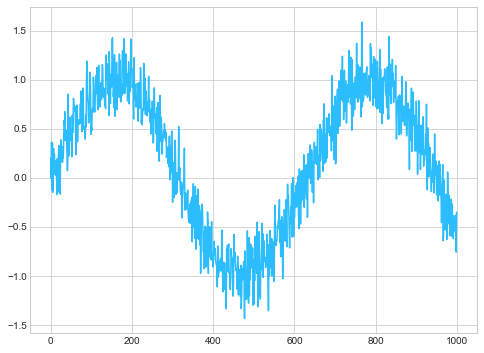

In [231]:
figsize = plt.figure(figsize=(8,6))
plt.plot(t, x, c=CB91_Blue)

In [217]:
step = 4
features = np.zeros(((T - step), step))
for i in range(step):
    features[:, i] = x[i: T - step + i]

labels = x[step:].reshape(-1, 1)

In [258]:
model = keras.models.Sequential([keras.layers.Dense(10, activation='relu', kernel_regularizer='l2'),
                                 keras.layers.Dense(1, kernel_regularizer='l2')])
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01))

In [260]:
n_train = 600
model.fit(features[:n_train], labels[:n_train], epochs=30, batch_size=32, )

Epoch 1/30
19/19 [==============================] - 0s 793us/step - loss: 0.0659
Epoch 2/30
19/19 [==============================] - 0s 825us/step - loss: 0.0653
Epoch 3/30
19/19 [==============================] - 0s 868us/step - loss: 0.0642
Epoch 4/30
19/19 [==============================] - 0s 1ms/step - loss: 0.0629
Epoch 5/30
19/19 [==============================] - 0s 1ms/step - loss: 0.0620
Epoch 6/30
19/19 [==============================] - 0s 1ms/step - loss: 0.0617
Epoch 7/30
19/19 [==============================] - 0s 949us/step - loss: 0.0614
Epoch 8/30
19/19 [==============================] - 0s 969us/step - loss: 0.0603
Epoch 9/30
19/19 [==============================] - 0s 1ms/step - loss: 0.0595
Epoch 10/30
19/19 [==============================] - 0s 1ms/step - loss: 0.0595
Epoch 11/30
19/19 [==============================] - 0s 1ms/step - loss: 0.0584
Epoch 12/30
19/19 [==============================] - 0s 2ms/step - loss: 0.0586
Epoch 13/30
19/19 [====================

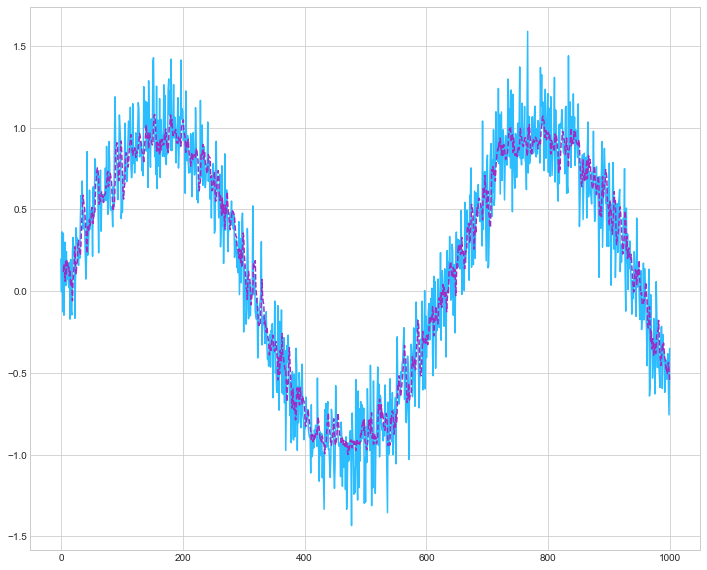

In [261]:
figsize = plt.figure(figsize=(12,10))
plt.plot(t, x, c=CB91_Blue)
plt.plot(t[step:], model.predict(features).reshape(-1), c=CB91_Purple, linestyle='--')

In [262]:
k_step_pred = np.zeros(T)
k_step_pred[: n_train + step] = x[: n_train + step]
for i in range(n_train + step, T):
    k_step_pred[i] = model.predict(k_step_pred[i - step: i].reshape(1, -1)) 

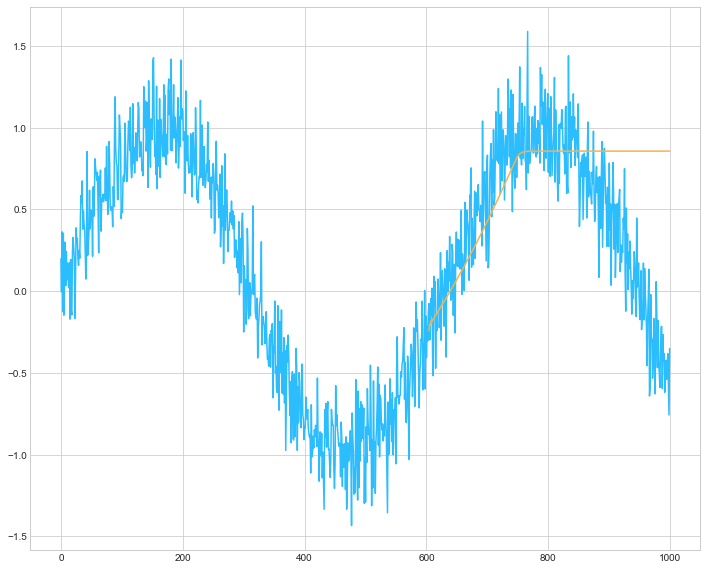

In [263]:
figsize = plt.figure(figsize=(12,10))
plt.plot(t, x, c=CB91_Blue)
plt.plot(t[n_train + step: ], k_step_pred[n_train + step: ], c=CB91_Amber)

In [611]:
import urllib3
import certifi
from collections import Counter
import numpy as np

In [612]:
http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',
                           ca_certs=certifi.where())

In [707]:
!curl http://www.manythings.org/anki/fra-eng.zip -o fra-eng.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 41 6300k   41 2617k    0     0   8855      0  0:12:08  0:05:02  0:07:06  2585:00:03  3:17:36   5440:00:05  0:02:05 622860:02:46  0:00:55  0:01:51 126120:01:14  0:02:16  7609:29  0:02:34  344700k   37 2347k    0     0  24566      0  0:04:22  0:01:37  0:02:45  3350  0:06:02  0:02:21  0:03:41  230775      0  0:06:13  0:02:25  0:03:48   706:08:19  0:03:20  0:04:59   5727      0  0:08:59  0:03:37  0:05:22  1318    0  0:09:33  0:03:52  0:05:41   3494:17  0:06:13  1096  9049      0  0:11:52  0:04:54  0:06:58     012:08  0:05:02  0:07:06  1607^C


In [614]:
import shutil
shutil.unpack_archive('fra-eng.zip', 'fra-eng', 'zip')

In [709]:
with open('rus-eng/rus.txt', 'r') as f:
    corpus = f.readlines()

FileNotFoundError: [Errno 2] No such file or directory: 'rus-eng/rus.txt'

In [616]:
def tokenize(sentence):
    return re.findall(r"[\w']+|[.,!?;]", sentence)

def get_eng_rus(corpus):
    lines = [line.split('\t') for line in corpus]
    eng = [tokenize(line[0].lower()) for line in lines]
    rus = [tokenize(line[1].lower()) for line in lines]
    return eng, rus

def vocab(source, min_feq=2, reserved_token=['<pad>', '<sos>', '<eos>']):
    counter = Counter([word for sent in source for word in sent ])
    token_feq = sorted(counter.items(), key=lambda item: item[1], reverse=True)
    unique_token = ['<unk>'] + reserved_token
    unique_token += [token[0] for token in token_feq if token[1] >= min_feq and token[0] not in unique_token]
    token_to_index = {token: index for index, token in enumerate(unique_token)}
    return unique_token, token_to_index

In [693]:
eng, rus = get_eng_rus(corpus)

In [694]:
eng_vocab = vocab(eng)
rus_vocab = vocab(rus)

In [619]:
def vectorize(sent, token_to_index):
    return [token_to_index.get(word, 0) for word in sent]

In [695]:
eng_index_to_token, eng_token_to_index = eng_vocab
rus_index_to_token, rus_token_to_index = rus_vocab

In [621]:
def padding(sent, num_steps, padding_token):
    if len(sent) > num_steps:
        return sent[:num_steps]
    return sent + [padding_token] * (num_steps - len(sent))

In [622]:
def build_array(sents, token_to_index, num_steps):
    sents = [vectorize(sent, token_to_index) + [token_to_index.get('<eos>')] for sent in sents]
    array = np.array([padding(sent, num_steps, token_to_index.get('<pad>')) for sent in sents])
    valid_len = (array != token_to_index.get('<pad>')).astype(np.int32).sum(1)
    return array, valid_len

def add_sos(array, token_to_index):
    start_seq = np.repeat(token_to_index.get('<sos>'), len(array))
    return np.c_[start_seq, array[:, :-1]]

In [696]:
encoder_input_data, src_valid_len = build_array(eng, eng_token_to_index, 8)
decoder_output_data, tgt_valid_len = build_array(rus, rus_token_to_index, 8)
decoder_input_data = add_sos(decoder_output_data, rus_token_to_index)

In [697]:
encoder_input_data = encoder_input_data[:, ::-1]

In [698]:
len(decoder_input_data)

7558

In [676]:
decoder_output_data[0]

array([318, 130,   3,   1,   1,   1,   1,   1])

In [703]:
encoder_vocab_size = len(eng_index_to_token)
encoder_embed_size = 64
decoder_vocab_size = len(rus_index_to_token)
decoder_embed_size = 64

encoder_input = keras.layers.Input(shape=[None], dtype=np.int32)
encoder_embeddings = keras.layers.Embedding(encoder_vocab_size, encoder_embed_size)(encoder_input)

decoder_input = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_embeddings = keras.layers.Embedding(decoder_vocab_size, decoder_embed_size)(decoder_input)

encoder = keras.layers.GRU(128, return_sequences=False, return_state=True)
encoder_output, h_state = encoder(encoder_embeddings) 

decoder_output, _ = keras.layers.GRU(128, return_sequences=True, return_state=True)(decoder_embeddings, initial_state=encoder_output)
decoder_out = keras.layers.Dense(decoder_vocab_size, activation='softmax')(decoder_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input], outputs=[decoder_out])

In [704]:
model.summary()

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_55 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, None, 64)     147520      input_54[0][0]                   
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, None, 64)     112000      input_55[0][0]                   
___________________________________________________________________________________________

In [705]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])

In [706]:
model.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
189/189 [==============================] - 8s 24ms/step - loss: 5.2445 - accuracy: 0.1607 - val_loss: 5.8183 - val_accuracy: 0.0651
Epoch 2/30
189/189 [==============================] - 4s 21ms/step - loss: 4.6244 - accuracy: 0.2171 - val_loss: 5.5427 - val_accuracy: 0.0931
Epoch 3/30
189/189 [==============================] - 4s 20ms/step - loss: 4.3029 - accuracy: 0.2726 - val_loss: 5.3008 - val_accuracy: 0.1449
Epoch 4/30
189/189 [==============================] - 4s 20ms/step - loss: 4.0551 - accuracy: 0.3054 - val_loss: 5.1823 - val_accuracy: 0.1591
Epoch 5/30
189/189 [==============================] - 4s 20ms/step - loss: 3.8748 - accuracy: 0.3274 - val_loss: 5.0933 - val_accuracy: 0.1716
Epoch 6/30
189/189 [==============================] - 4s 20ms/step - loss: 3.7260 - accuracy: 0.3479 - val_loss: 5.0301 - val_accuracy: 0.1836
Epoch 7/30
189/189 [==============================] - 4s 20ms/step - loss: 3.5948 - accuracy: 0.3662 - val_loss: 4.9748 - val_accuracy: 0.1961

KeyboardInterrupt: 

In [522]:
model.layers[2].name

'embedding_39'

In [681]:
encoder_input = model.inputs[0]
encoder_embedding = model.layers[2](encoder_input)

In [682]:
encoder_output, encoder_state = model.layers[4](encoder_embedding)

In [683]:
encoder_model = keras.Model(encoder_input, encoder_state)

In [684]:
decoder_input = model.inputs[1]
decoder_embedings = model.layers[3](decoder_input)

In [685]:
decoder_input_state = keras.layers.Input(shape=[128, ])

In [686]:
decoder_gru = model.layers[5]
decoder_output, decoder_output_state = decoder_gru(decoder_embedings, initial_state=[decoder_input_state])

In [687]:
decoder_output = model.layers[6](decoder_output)

In [688]:
decoder_model = keras.Model([decoder_input, decoder_input_state], [decoder_output, decoder_output_state])

In [689]:
max_seq = 20
def decoder_seq(input_seq):
    init_state = encoder_model(input_seq)

    end_condition = False
    target_input = np.expand_dims(rus_token_to_index.get('<sos>'), axis=[0, 1])
    decoded_sent = ""
    while not end_condition:
        decoder_output, init_state = decoder_model([target_input, init_state])
        decode_char_index = np.argmax(decoder_output[0, -1, :])
        decoded_sent += rus_index_to_token[decode_char_index]
        
        if decode_char_index == rus_token_to_index.get('<eos>') or len(decoded_sent) > max_seq:
            end_condition = True
            
        target_input = np.expand_dims(decode_char_index, axis=[0, 1])
        print(target_input)
    
    return decoded_sent

In [692]:
decoder_seq(np.array([[   1,    1,    1,    1,    1,    3,  112, 1322]]))

[[87]]
[[20]]
[[100]]
[[100]]
[[4]]
[[3]]


'hãynóithậtthật.<eos>'

In [691]:
encoder_input_data[3]

array([   1,    1,    1,    1,    1,    3,  112, 1322])

In [690]:
rus[3]

['chào', 'bạn', '.']

In [715]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(100)).batch(10).batch(4)

In [716]:
next(iter(dataset))

<tf.Tensor: shape=(4, 10), dtype=int32, numpy=
array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]], dtype=int32)>

In [719]:
b = np.expand_dims(a, axis=[-1, -2])

In [721]:
dense = keras.layers.Dense(1)

In [722]:
dense(b)

<tf.Tensor: shape=(1, 4, 1, 1), dtype=float32, numpy=
array([[[[-1.1476626]],

        [[-2.2953253]],

        [[-3.442988 ]],

        [[-4.5906506]]]], dtype=float32)>

In [729]:
c = np.arange(64).reshape(2, 2, 4, 4)

In [731]:
c.dot(np.arange(4).reshape(-1, 1)).shape

(2, 2, 4, 1)